In [1]:
import os 
import pandas as pd
import numpy as np
import pickle

import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from blendxpz.training.dataset_generator import batched_ExCOSMOS
from blendxpz.simulations.btk_setup import btk_setup_helper
from blendxpz.pz_estimators.mlp import create_mpl_estimator
from blendxpz.utils import (
    get_blendxpz_config_path,
    get_data_dir_path,
    get_madness_config_path,
    column_order,
)
from pdf2image import convert_from_path
import blendxpz.utils as blendxpz_utils 

import tensorflow as tf
import yaml

mpl.rcParams["text.usetex"] = True
mpl.rcParams["savefig.dpi"] = 1200
plt.rcParams[
    "text.latex.preamble"
] = r"\usepackage{bm} \usepackage{amsmath}" 

2024-07-19 16:26:01.358884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-19 16:26:01.613366: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 16:26:01.624375: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2024-07-19 16:26:01.62

In [2]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

scarlet_plot_label = r"\textsc{scarlet}"
madness_plot_label = r"\texttt{MADNESS}"
debvader_plot_label = r"\texttt{VAE-deblender}"

In [3]:
sns.set_theme(
    font_scale=1.5,
    style={
        "style": "whitegrid",
        "xtick.bottom": True,
        "axes.grid": True,
        "xtick.top": False,
        "ytick.left": True,
        "ytick.right": False,
        "text.color": ".1",
        "xtick.color": ".1",
        "ytick.color": ".1",
        "axes.edgecolor": ".85",
        "axes.labelcolor": ".1",
    },
    rc={"grid.color": ".85", "grid.linestyle": "--"},
)


In [4]:
with open(get_blendxpz_config_path()) as f:
    blendxpz_config = yaml.safe_load(f)

with open(get_madness_config_path()) as f:
    madness_config = yaml.safe_load(f)

In [5]:
survey_name = blendxpz_config["SURVEY_NAME"]

if survey_name not in ["LSST", "HSC"]:
    raise ValueError("survey should be one of: LSST or HSC")

_, _, survey = btk_setup_helper(
    survey_name=survey_name,
)

In [6]:
pz_estimator = create_mpl_estimator(6)
estimator_name = "mlp"
estimator_label = r"\texttt{MLP-pz}"

2024-07-19 16:26:17.242429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/:
2024-07-19 16:26:17.242636: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-07-19 16:26:17.242683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jns-bbiswas.cc.in2p3.fr): /proc/driver/nvidia/version does not exist
2024-07-19 16:26:17.243392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlo

# Load data

In [7]:
density_level = "high"

data_path = os.path.join(
    madness_config["RESULTS_PATH"][survey.name],
    density_level + "_density",
)
run_name = "kl2"  # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [8]:
madness_results = []
debvader_results = []
scarlet_results = []
actual_photometry = []
blended_photometry = []

for file_num in range(200):

    madness_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
        )
    )
    debvader_results.append(
        pd.read_pickle(
            os.path.join(result_dir_path, "debvader_results", str(file_num) + ".pkl")
        )
    )
    scarlet_results.append(
        pd.read_pickle(
            os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")
        )
    )

    actual_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")
        )
    )
    blended_photometry.append(
        pd.read_pickle(
            os.path.join(data_path, "blended_photometry", str(file_num) + ".pkl")
        )
    )

madness_results = pd.concat(madness_results)
debvader_results = pd.concat(debvader_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [9]:
blended_photometry.columns

Index(['g_phot_flux', 'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux',
       'r_phot_fluxerrs', 'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs',
       'i_phot_flags', 'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags',
       'y_phot_flux', 'y_phot_fluxerrs', 'y_phot_flags', 'galaxy_num',
       'field_num', 'file_num'],
      dtype='object')

In [10]:
for band in survey.available_filters:

    z_point = survey.get_filter(band).zeropoint
    exp_time = survey.get_filter(band).full_exposure_time

    actual_phot_mag = actual_photometry[f"{band}_phot_flux"].values
    actual_photometry[f"{band}_phot_mag"] = (
        (actual_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

    blended_phot_mag = blended_photometry[f"{band}_phot_flux"].values
    blended_photometry[f"{band}_phot_mag"] = (
        (blended_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value

    madness_phot_mag = madness_results[f"{band}_phot_flux"].values
    madness_results[f"{band}_phot_mag"] = (
        (madness_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) + z_point
    ).value


/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units

In [11]:
# for file_num in range(200):
#     print(file_num)
#     madness_res = pd.read_pickle(
#         os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")
#     )
    
#     simulation_path = os.path.join(madness_config["TEST_DATA_PATH"][survey_name], "high")

#     file_name = os.path.join(
#         simulation_path,
#         str(file_num) + ".pkl",
#     )

#     with open(file_name, "rb") as f:
#         blend = pickle.load(f)
    
#     current_pz = []
#     for field_num in range(len(blend.catalog_list)):
#         current_pz.extend(blend.catalog_list[field_num]["ZPHOT"])
        
#     madness_res["pz"] = current_pz

#     pd.to_pickle(
#         madness_res,
#         os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl"),
#     )
    

In [12]:
madness_results.columns

Index(['g_cosd', 'g_ssim', 'g_blendedness', 'r_cosd', 'r_ssim',
       'r_blendedness', 'i_cosd', 'i_ssim', 'i_blendedness', 'z_cosd',
       'z_ssim', 'z_blendedness', 'y_cosd', 'y_ssim', 'y_blendedness',
       'galaxy_num', 'field_num', 'file_num', 'latent_rep', 'r_band_snr',
       'g_ab', 'r_ab', 'i_ab', 'z_ab', 'y_ab', 'size', 'pz', 'g_phot_flux',
       'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux', 'r_phot_fluxerrs',
       'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs', 'i_phot_flags',
       'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags', 'y_phot_flux',
       'y_phot_fluxerrs', 'y_phot_flags', 'r_e', 'r_e1', 'r_e2',
       'r_contamination', 'g_phot_mag', 'r_phot_mag', 'i_phot_mag',
       'z_phot_mag', 'y_phot_mag'],
      dtype='object')

## load normalization mu and sigma

In [13]:
blend_type="isolated"

In [14]:
BASE_DATA_PATH = madness_config["btksims"]["TRAIN_DATA_SAVE_PATH"][survey_name]

In [15]:
norms_path = os.path.join(
    BASE_DATA_PATH, blend_type + "_training", "norms.pkl"
)
with open(norms_path, 'rb') as f:
    norms = pickle.load(f)

In [16]:
m1 = actual_photometry.isnull().any(axis=1).values
m2 = madness_results.isnull().any(axis=1).values
m3 = blended_photometry.isnull().any(axis=1).values

In [17]:
mask_null = m1 | m2 | m3

In [18]:
np.sum(mask_null)

4981

In [19]:
mask_redshift = madness_results["pz"]<2

In [20]:
mask=actual_photometry["i_phot_flux"]/actual_photometry["i_phot_fluxerrs"]>5
mask=mask & ~ mask_null & mask_redshift

In [21]:
#mask = np.array([1]*len(actual_photometry)).astype('bool')

In [22]:
np.sum(mask)

41082

In [23]:
len(mask)

63908

# Load Model 

In [24]:
data_path = get_data_dir_path()
weights_path = os.path.join(
    data_path, 
    "models", 
    survey.name + f"_{estimator_name}_estimator", 
    "val_loss",
)
weights_path = tf.train.latest_checkpoint(weights_path)
pz_estimator.load_weights(weights_path).expect_partial()

# Run the estimator 

In [25]:
cols_to_extract=[]
for band in survey.available_filters:
    cols_to_extract.append(f"{band}_phot_mag")

In [26]:
madness_extracted = madness_results[cols_to_extract]
blended_extracted = blended_photometry[cols_to_extract]
actual_extracted = actual_photometry[cols_to_extract]

for band in survey.available_filters:
    col = f"{band}_phot_mag"
    madness_extracted[col] = (madness_extracted[col] - norms['mu'][band])/norms['sigma'][band]
    blended_extracted[col] = (blended_extracted[col] - norms['mu'][band])/norms['sigma'][band]
    actual_extracted[col] = (actual_extracted[col] - norms['mu'][band])/norms['sigma'][band]
    
madness_extracted["flux_radius"] = madness_results["size"]/10
blended_extracted["flux_radius"] = madness_results["size"]/10
actual_extracted["flux_radius"] = madness_results["size"]/10

/tmp/ipykernel_1006/3669146853.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  madness_extracted[col] = (madness_extracted[col] - norms['mu'][band])/norms['sigma'][band]
/tmp/ipykernel_1006/3669146853.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blended_extracted[col] = (blended_extracted[col] - norms['mu'][band])/norms['sigma'][band]
/tmp/ipykernel_1006/3669146853.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [27]:
cols=column_order(survey)
madness_pred = pz_estimator(madness_extracted[cols].to_numpy())
blended_pred = pz_estimator(blended_extracted[cols].to_numpy())
actual_pred = pz_estimator(actual_extracted[cols].to_numpy())

In [28]:
len(madness_pred)

63908

In [29]:
np.sum(mask)

41082

In [30]:
scarlet_plot_color = sns.color_palette("colorblind")[4]
madness_plot_color = sns.color_palette("colorblind")[0]
debvader_plot_color = sns.color_palette("colorblind")[2]

isolated_plot_color = sns.color_palette("colorblind")[6]
blended_plot_color = sns.color_palette("colorblind")[1]

madness_plot_ls = "dashdot"
debvader_plot_ls = "dotted"
scarlet_plot_ls = "-"

isolated_plot_ls = "dotted"
blended_plot_ls = "--"

In [31]:
delta_z_b = blended_pred.numpy().flatten()[mask] - madness_results['pz'][mask].values
delta_z_m = madness_pred.numpy().flatten()[mask] - madness_results['pz'][mask].values

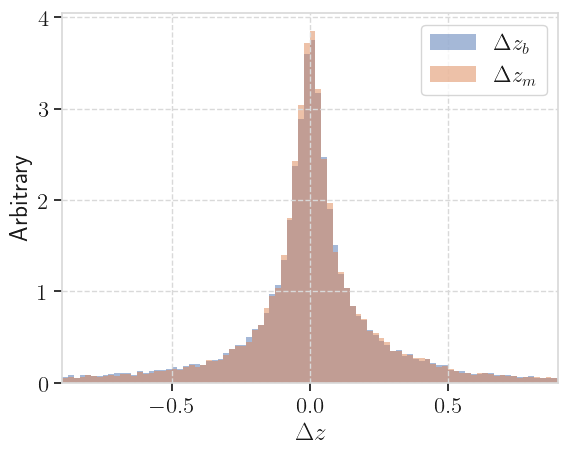

In [32]:
bins=plt.hist(delta_z_b, bins=200, alpha=.5, density=True, label=r"$\Delta z_b$")
plt.hist(delta_z_m, bins=bins[1], alpha=.5, density=True, label=r"$\Delta z_m$");
plt.xlabel(r"$\Delta z$")
plt.ylabel("Arbitrary")
plt.legend()
plt.xlim((-.9, .9))
plt.savefig(
    os.path.join(
        "results",
        f"redshift_residual.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)

In [33]:
np.std(delta_z_m/(1+actual_pred.numpy().flatten()[mask]))

0.19325387407349404

In [34]:
np.std(delta_z_b/(1+actual_pred.numpy().flatten()[mask]))

0.19832940389996775

In [35]:
outlier_rate_original = np.abs(madness_results['pz'].values[mask] - actual_pred.numpy().flatten()[mask])/(1+madness_results['pz'][mask].values) > .15
outlier_madness_original = np.abs(madness_results['pz'].values[mask] - madness_pred.numpy().flatten()[mask])/(1+madness_results['pz'][mask].values) > .15
outlier_blended_original = np.abs(madness_results['pz'].values[mask] - blended_pred.numpy().flatten()[mask])/(1+madness_results['pz'][mask].values) > .15

In [36]:
actual_outlier = round(np.sum(outlier_rate_original)/len(outlier_rate_original), 3)
madness_outlier = round(np.sum(outlier_madness_original)/len(outlier_rate_original), 3)
blended_outlier = round(np.sum(outlier_blended_original)/len(outlier_rate_original), 3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


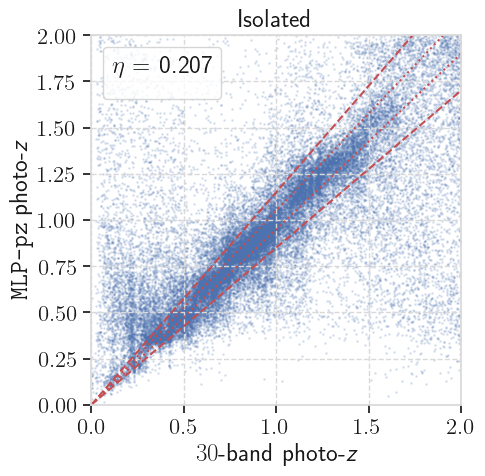

In [53]:
#batch = next(ds_isolated_train)
plt.scatter(madness_results['pz'][mask].values, actual_pred.numpy().flatten()[mask], alpha=.15, s=1)
plt.plot([0, 10], [0, 11.5], c="r", ls="--")
plt.plot([0, 10], [0, 8.5], c="r", ls="--")

plt.plot([0, 10], [0, 10.5], c="r", ls=":")
plt.plot([0, 10], [0, 9.5], c="r", ls=":")

plt.xlim((0, 2))
plt.ylim((0, 2))

ax = plt.gca()
ax.set_aspect('equal', 'box')

plt.ylabel(fr"{estimator_label} photo-\textit{{z}}")
plt.xlabel(fr"$30$-band photo-\textit{{z}}")

plt.title("Isolated")
plt.legend(title=fr"$\eta$ = {actual_outlier}", loc="upper left")

plt.savefig(os.path.join("results", "temp", "isolated.pdf"),
    format="pdf",
    bbox_inches="tight",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


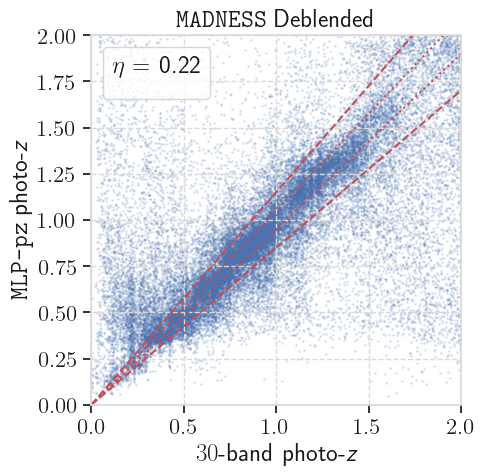

In [55]:
plt.scatter(madness_results['pz'][mask].values, madness_pred.numpy().flatten()[mask], alpha=.15, s=1)
plt.plot([0, 10], [0, 11.5], c="r", ls="--")
plt.plot([0, 10], [0, 8.5], c="r", ls="--")

plt.plot([0, 10], [0, 10.5], c="r", ls=":")
plt.plot([0, 10], [0, 9.5], c="r", ls=":")

plt.xlim((0,2))
plt.ylim((0,2))

ax = plt.gca()
ax.set_aspect('equal', 'box')

plt.ylabel(fr"{estimator_label} photo-\textit{{z}}")
plt.xlabel(fr"$30$-band photo-\textit{{z}}")

plt.title(r"\texttt{MADNESS} Deblended")
plt.legend(title=fr"$\eta$ = {madness_outlier}", loc="upper left")
plt.savefig(
    os.path.join("results", "temp", "madness_deblended.pdf"),
    format="pdf",
    bbox_inches="tight",
)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


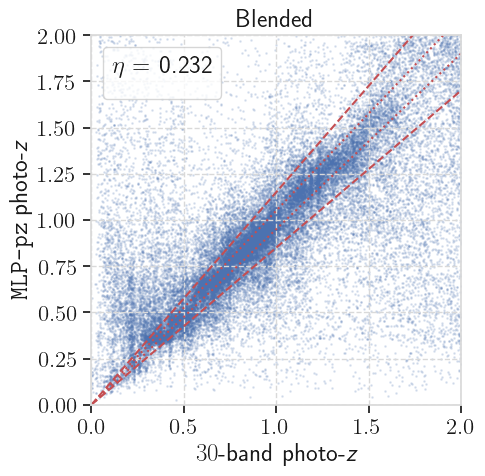

In [56]:
plt.scatter(madness_results['pz'][mask].values, blended_pred.numpy()[mask], alpha=.15, s=1)
plt.plot([0, 10], [0, 11.5], c="r", ls="--")
plt.plot([0, 10], [0, 8.5], c="r", ls="--")

plt.plot([0, 10], [0, 10.5], c="r", ls=":")
plt.plot([0, 10], [0, 9.5], c="r", ls=":")

plt.xlim((0, 2))
plt.ylim((0, 2))

ax = plt.gca()
ax.set_aspect('equal', 'box')

plt.ylabel(fr"{estimator_label} photo-\textit{{z}}")
plt.xlabel(fr"$30$-band photo-\textit{{z}}")


plt.title("Blended")
plt.legend(title=fr"$\eta$ = {blended_outlier}", loc="upper left")

plt.savefig(os.path.join("results", "temp", "Blended.pdf"), format="pdf",
    bbox_inches="tight",)

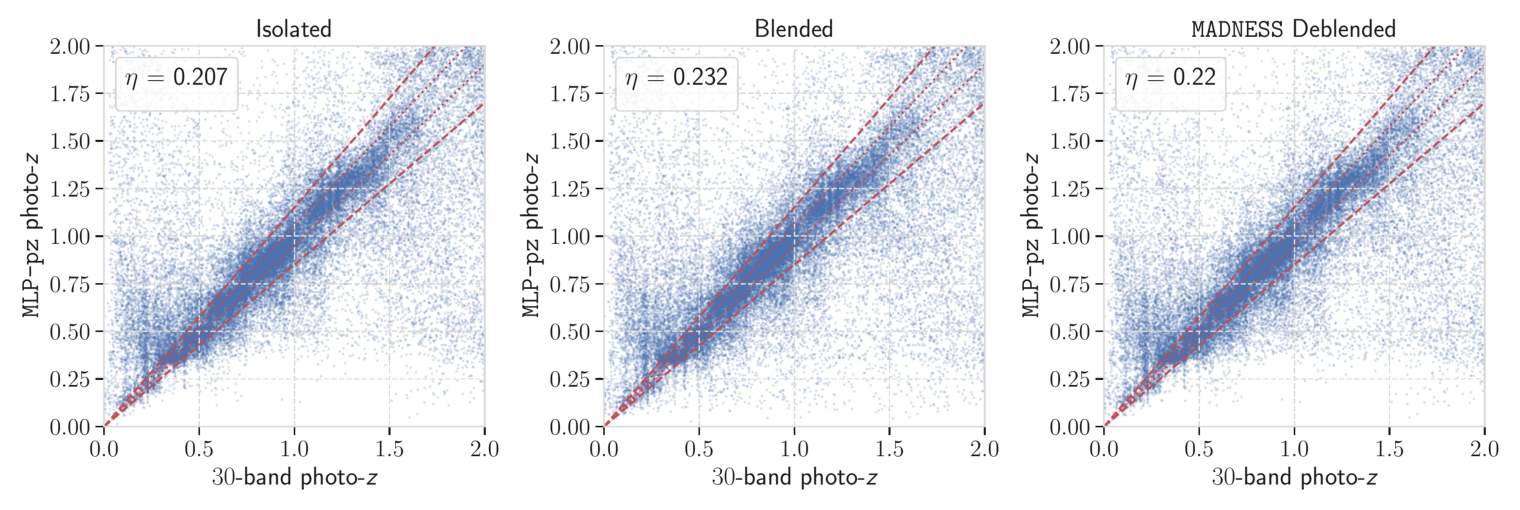

In [57]:
f, axarr = plt.subplots(1, 3, figsize=(15, 5))

# axarr[0].imshow(mpimg.imread(os.path.join(result_dir_pth, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(
    convert_from_path(os.path.join("results", "temp", "isolated.pdf"))[0]
)
axarr[1].imshow(
    convert_from_path(os.path.join("results", "temp", "Blended.pdf"))[0]
)
axarr[2].imshow(
    convert_from_path(os.path.join("results", "temp", "madness_deblended.pdf"))[0]
)

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
[ax.margins(y=0, x=0) for ax in axarr.ravel()]


plt.tight_layout(pad=0)

plt.savefig(
    os.path.join("results", "pz-results.pdf"),
    format="pdf",
    bbox_inches="tight",
)

plt.show()

In [43]:
(madness_results['pz'][mask].values - actual_pred.numpy()[mask].flatten())

array([-0.05916929, -1.05009252,  0.06244063, ...,  0.52378678,
       -0.03798956, -1.69047114])

In [44]:
outlier_blended_original

array([False,  True, False, ...,  True, False,  True])

In [52]:
np.sum(outlier_rate_original)/len(outlier_rate_original)

0.2066841925904289

In [46]:
np.sum(outlier_madness_original)/len(outlier_rate_original)

0.2198529769728835

In [47]:
np.sum(outlier_blended_original)/len(outlier_rate_original)

0.23187770799863688

In [60]:
gr_actual

array([2.58474154e-01, 1.90238307e-01, 1.34312494e-04, ...,
                  nan, 2.64866407e-01, 2.81535098e-01])

In [90]:
gr_actual =  actual_photometry[f"g_phot_mag"][mask].values -  actual_photometry[f"r_phot_mag"][mask].values
gr_blended =  blended_photometry[f"g_phot_mag"][mask].values -  blended_photometry[f"r_phot_mag"][mask].values
gr_madness =  madness_results[f"g_phot_mag"][mask].values -  madness_results[f"r_phot_mag"][mask].values

In [91]:
ri_actual =  actual_photometry[f"r_phot_mag"][mask].values -  actual_photometry[f"i_phot_mag"][mask].values
ri_blended =  blended_photometry[f"r_phot_mag"][mask].values -  blended_photometry[f"i_phot_mag"][mask].values
ri_madness =  madness_results[f"r_phot_mag"][mask].values -  madness_results[f"i_phot_mag"][mask].values

In [92]:
sns_df = {}
sns_df[r"$g-r$ color"] = gr_actual.tolist() + gr_blended.tolist() + gr_madness.tolist()
sns_df[r"$r-i$ color"] = ri_actual.tolist() + ri_blended.tolist() + ri_madness.tolist()
sns_df["Blend Type"] = len(gr_actual.tolist())*["Isolated"] + len(gr_blended.tolist())*["Blended"] + len(gr_madness.tolist())*["Deblended"]

In [93]:
sns_df = pd.DataFrame(sns_df)

In [94]:
sns_df

,$g-r$ color,$r-i$ color,Blend Type
0,0.258474,0.129352,Isolated
1,0.190238,0.365094,Isolated
2,0.000134,-0.027788,Isolated
3,0.503094,0.353642,Isolated
4,-0.071566,0.921267,Isolated
...,...,...,...
123241,-0.106169,0.871533,Deblended
123242,0.844745,0.689491,Deblended
123243,-0.032464,0.388320,Deblended
123244,0.264785,0.635587,Deblended


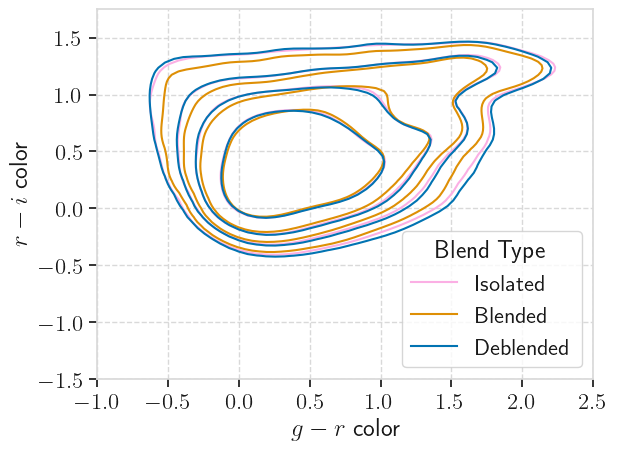

In [111]:
ax=sns.kdeplot(data=sns_df, hue_order=["Isolated", "Blended", "Deblended"], bw_method=.25, hue="Blend Type", x=r"$g-r$ color", y=r"$r-i$ color", cut=0, palette=[isolated_plot_color, blended_plot_color, madness_plot_color], levels=[.05, .1, .2, .4], legend=True)

plt.xlim((-1, 2.5))
plt.ylim((-1.5, 1.75))
sns.move_legend(ax, "lower right")
plt.savefig(
    os.path.join(
        "results",
        f"color-color_diagram.pdf",
    ),
    format="pdf",
    bbox_inches="tight",
)